# NSP Bootcamp Day 2: Putting python skills into practice
## Extracting spiking information from extracellular electrophysiology data

<br>


The best way to learn coding is to do, so lets take some of the concepts from the Introduction.ipynb that we went through yesterday and put them in to practice. If thinking of this notebook from yesterday brings a memory of total confusion and bafflement, take this time to go back to that notebook and work through it again. If not, go forth with this notebook! Feel free to work with your neighbor as you go. 


Goal: use some raw extracellular electrophysiology voltage data, along with some times for when other things (similar to the awake behavior seen in Crystal's experiments) occurred during the recording, to:
- examine the recorded voltages
- find some times of action potentials from these voltages
- correlate these times of action potentials with an experimental variable 

The data come from the Denman Lab. We will work toward making a plot like this, a raster of spike times around two different visual stimuli:
![raster](../res/raster2.png) 

##### Some of the code is pre-written, and you will simply execute it. In other cases, you will be prompted to write some code lines to advance towards this goal. **There are going to be 8 such prompts,** plus some bonus challenges if you want to keep going.

## Imports of packages we will need for this notebook. 
#### All are standard and those that we have talked about

In [71]:
!pip install h5py pynwb

  Using cached pynwb-2.8.1-py3-none-any.whl.metadata (8.9 kB)
  Using cached ruamel.yaml-0.18.6-py3-none-any.whl.metadata (23 kB)
  Using cached ruamel.yaml.clib-0.2.8-cp312-cp312-macosx_10_9_universal2.whl.metadata (2.2 kB)
Using cached pynwb-2.8.1-py3-none-any.whl (1.4 MB)
Using cached ruamel.yaml-0.18.6-py3-none-any.whl (117 kB)
Using cached ruamel.yaml.clib-0.2.8-cp312-cp312-macosx_10_9_universal2.whl (144 kB)


In [1]:
import os,sys,glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import h5py
from pynwb import NWBHDF5IO


### Now we will get the Neuropixels data from a Denman Lab server. 
The details of this are not critical, and can be ignored for now in order to get the rest of this notebook. 
So, some Jupyter practice: press ```Shift + Enter``` to run a cell and advance to the next one
<br>
<br>
This kind of data can be quite large; we are going to download a subset of the data for working today, but it will still take a few minutes (10 or fewer if you have a decent internet connection). Feel free to read down and begin thinking about how to tackle the questions.

In [178]:
from urllib.request import urlretrieve
urlretrieve("https://storage.googleapis.com/denmanlab/s1/autobahn/20210922_3592_ABC_g0.nwb",
             "20210922_3592_ABC_g0.nwb")
urlretrieve("https://storage.googleapis.com/nsp_bootcamp/spikes.npy",
             "spikes.npy")
urlretrieve("https://storage.googleapis.com/nsp_bootcamp/20210922_3592_ABC_g0_t0.imec0.lf.bin",
             "lfp.dat")

('lfp.dat', <http.client.HTTPMessage at 0x122042d670>)

In [2]:
lfp_data = np.memmap('lfp.dat', dtype=np.int16, mode='r')

### **Question 1. what kind type of variable is `lfp_data`?** 
hint: use a function that returns the data type of the input it receives. there are also other ways to find this answer

In [3]:
type(lfp_data)

numpy.memmap

so `lfp_data` is a ____. (not going to just give this answer...you can edit this Markdown cell to replace the blank with the data type of `lfp_data`)

it will be easier for us to work with as an array. i will grab a small(ish) chunk of the whole data and make it into a numpy ndarray


In [4]:
lfp_data = lfp_data.reshape(-1,385).T

In [5]:
lfp_data = np.array(lfp_data[:,:2500*1500])

so we've reshaped the data and made it into an ndarray. i will give you that this new shape has time along one dimension, and independent electrodes along the other dimension. there will be more time samples than electodes. 

### **Question 2. How many independent electrodes are there in `lfp_data`?**
To help answer this, note that there are 3750000 samples of time in this chunk of data


great, we are making some progress in understanding the type and shape of this data, but what is it? We are working extracellular electrophysiology data from Neuropixels in the exercise, and we've begun with something called `lfp_data`. why is it called this? it is the *L*ocal *F*ield *Potential*, or the voltage changes recorded at each electrode when filtered to slow the "slower" changes in voltage (< 300 Hz). Let's take a quick look at one of these channels, channel 50:

Text(0, 0.5, 'µV')

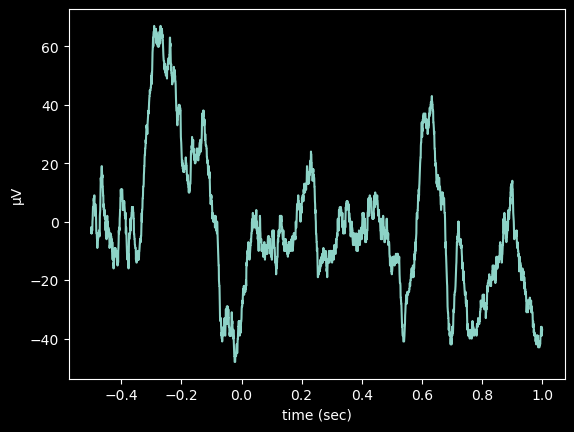

In [6]:
plt.plot(np.linspace(-0.5,1.,2500),lfp_data[50,268832:271332])
plt.xlabel('time (sec)')
plt.ylabel('µV')

### **Question 3. plot the same time range, but for channel 95 of `lfp_data`?**

The two plots of the LFP from two channels of this recording have some shared characteristics, but also some differences between them. As we briefly covered this morning, the LFP reflects a summation of many small potentials from many neurons in the area around the electrode. So we see that neurons have some shared potentials across different locations (these two electrodes are 450 µm apart), but also some differences. There is more depth to this signal, but we will leave other topics in LFP analysis - periodic activity (a.k.a. oscillations), coherence, current source density - to future topics.

Fast changes in the potential outside of a neuron happen as a result of action potentials - spikes - the basic unit of brain communication. 

<br>
How do we find these from extracellular recordings? First, we have to isolate those fast changes from the slower LFP signals, which for Neuropixels happens in the hardware on the probe and is saved in a separate band. Instead of loading all of the spiking data (it would be too big for convenience), we'll load just four channels that I've selected for you:

In [7]:
spikes_data = np.load('spikes.npy')

In [9]:
spikes_data.shape

(4, 10281600)

There are 30000 samples per second in this data. We'll create a one dimensional array that corresponds to time in seconds of each sample in the `spikes_data`

In [10]:
times_spike_data = np.linspace(0,np.shape(spikes_data)[1]/30000.,np.shape(spikes_data)[1])

### **Question 4. Plot the spikes data, 50.0 - 58.0 seconds on each of these four channels**

Remember this morning that the spiking data from an in-vivo Neuropixels recording is typically run through an automated template matching algorithm:

And then following that, manually annotated to generated labels:

We're going to do a *much* simplified version of spike extraction as an exercise here with these four channels

### **Question 5. For each of these channels, find the times that voltage is more negative than -23µV**
make four arrays of spike times, one for each channel

To correlate these spikes with an experimental variable, we need the times of those variables

In the Denman Lab (and many other labs), the final step is to package these labelled neurons along with stimulus information into a single file with a standardized data format (just like a .pdf or a .jpeg is a standardized format): a Neurodata Without Borders File. We will load the nwb for this experiment so we can get some visual stimulus times

In [11]:
nwb = h5py.File('20210922_3592_ABC_g0.nwb','r')
io = NWBHDF5IO('20210922_3592_ABC_g0.nwb', mode='r',load_namespaces=True)
nwb_ = io.read()

/Users/danieljdenman/opt/anaconda3/envs/nspbootcamp2024/lib/python3.12/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Users/danieljdenman/opt/anaconda3/envs/nspbootcamp2024/lib/python3.12/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/Users/danieljdenman/opt/anaconda3/envs/nspbootcamp2024/lib/python3.12/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


this file has information about the neurons extracted from this experiment, as well as other things about the experiment like behavioral outputs, videos of behavior (like motor vidoes) or sensory inputs.

Let's first get a tiny fraction of the sensory inputs: visual flashes. we will assign them to a variable called `flashes`

In [12]:
flashes = nwb['intervals']['trials']['start_time'][:100]

In [13]:
print(np.shape(flashes))

(100,)


so we have 100 total flashes. the values here are times, in seconds, when these flashed stimuli happened. Use iteration, or a function, to find out how much time is in between each flashed stimulus. 
### **Question 7. What are all the times in between flashed stimuli in this experiment? After you find all of the times, then find the mean and standard deviation of times between flashes?** 


The flashes come in two flavors ('bright' and 'dark'), which alternate.
### **Question 8. Make two separate arrays, one for bright stimuli and one for dark stimuli** 


### **Question 9. For each bright time, find the spike times from a channel you extracted in Question 5 that occured within the 0.6 seconds after the stimulus**
As you find these times, find them *relative to the stimulus time*, so all the times you record end up being between 0 and 0.6. keep a separate list for each trial.  


We also happen to have all of the extracted and annotated spike times from many neurons in this recording (way more than from the four channels we've used above!). We can get them from the nwb and put then in a pandas DataFrame called df


In [76]:
df = nwb_.units.to_dataframe()

### **Bonus Question. How many neurons were isloated in this recording?**

### **Bonus Question. Repeat question 9 for the neuron 59 in the id column of df?**

### **Bonus Question. Plot the relative time of each spike of neuron 59 to each bright stimulus and each dark stimulus - a raster like the very top plot in this notebook**